In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import glob
from math import sqrt
from pprint import pprint
from time import gmtime, strftime
SPINE_COLOR = 'gray'

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8,       #'text.fontsize': 8, # was 10
              'legend.fontsize': 6.5, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'lines.linewidth' : 0.4,
              'lines.markersize' : 0.4,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

linewidth=497
DPI=96
#latexify(fig_width=linewidth/DPI, fig_height=int(linewidth/2.3/DPI))
latexify(fig_width=linewidth/DPI/1.7, fig_height=int(linewidth/2.3/DPI))

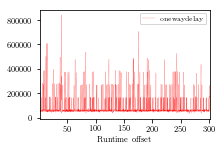

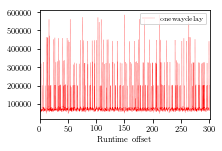

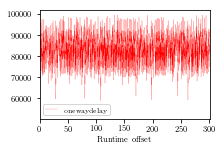

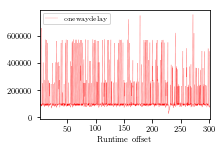

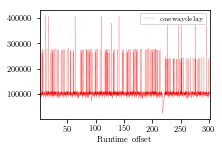

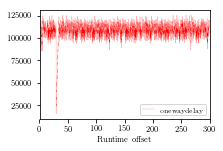

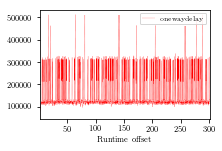

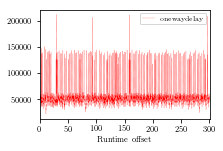

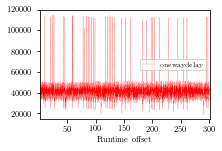

In [195]:
for f in glob.iglob('./*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    fig = dfapp.plot(x='seconds_offset', y='onewaydelay', color='r', linestyle=':')
    axes = plt.gca() 
    #axes.set_ylim([0,100000])
    fig.set_xlabel('Runtime offset')

./crosstraffic_mqs-6\20191206-1752-crosstraffic-non-ephemeral\
3000
Outdated: 332 min: 114.305 mean: 213.55587349397587 median: 167.9405 max: 483.91  (all delays in ms)
MsgsInTime: 2668 min: 33.23 mean: 59.178994377811065 median: 59.376000000000005 max: 83.971  (all delays in ms)

./crosstraffic_mqs-6\20191206-1757-crosstraffic-light-ephemeral\
3000
Outdated: 223 min: 138.339 mean: 233.61608968609875 median: 165.856 max: 717.298  (all delays in ms)
MsgsInTime: 2777 min: 35.299 mean: 59.87643644220387 median: 60.052 max: 75.771  (all delays in ms)

./crosstraffic_mqs-6\20191206-1802-crosstraffic-full-ephemeral\
2942
Outdated: 351 min: 149.074 mean: 157.37184045584047 median: 154.937 max: 173.426  (all delays in ms)
MsgsInTime: 2591 min: 22.695 mean: 58.57615592435358 median: 58.975 max: 74.341  (all delays in ms)

./crosstraffic_mqs-6\20191206-1812-crosstraffic-non-ephemeral\
3000
Outdated: 511 min: 101.349 mean: 180.24527005870834 median: 156.729 max: 608.367  (all delays in ms)
MsgsIn

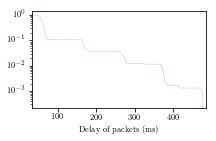

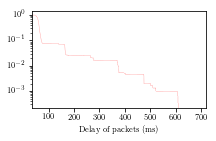

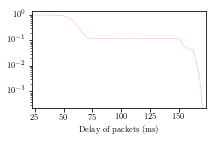

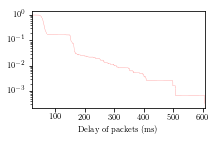

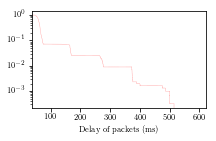

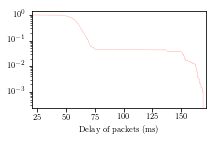

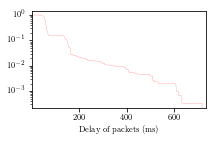

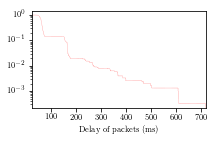

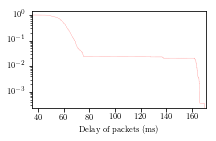

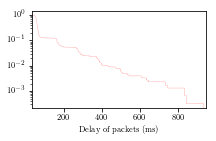

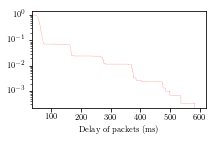

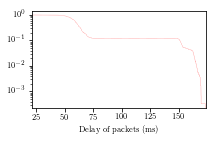

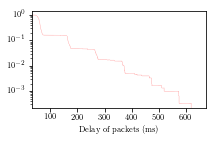

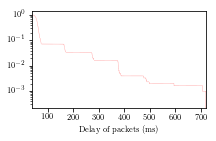

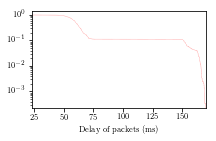

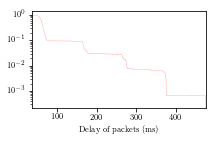

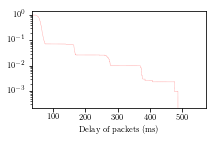

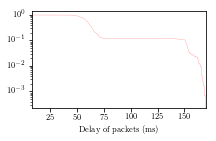

In [198]:
#CCDFs
# one-way delay (application layer)
for f in glob.iglob('./crosstraffic_mqs-6/*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfapp['length']
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    sortedOneWayDelay = dfapp['onewaydelay'].sort_values()
    print(sortedOneWayDelay.size)
    
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfapp.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)
            
    print('Outdated:', outdated.size, 'min:', outdated.min(), 'mean:', outdated.mean(), 
            'median:', outdated.median(), 'max:', outdated.max(), ' (all delays in ms)')
    print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
            'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)\n')
    
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedOneWayDelay))
    cdf = pd.Series(cum_dist, index=sortedOneWayDelay)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Delay of packets (ms)')
    fig.set_yscale('log')
    plt.tight_layout()
    plt.savefig(f+"ccdf_one-way-delay_app.pdf")

./crosstraffic_mqs-6\20191206-1752-crosstraffic-non-ephemeral\
3000
Outdated: 223 min: 138.079 mean: 217.2253856502242 median: 165.544 max: 483.886  (all delays in ms)
MsgsInTime: 2777 min: 33.215 mean: 59.24394778537976 median: 59.493 max: 75.433  (all delays in ms)

./crosstraffic_mqs-6\20191206-1757-crosstraffic-light-ephemeral\
3000
Outdated: 223 min: 138.221 mean: 233.52343946188338 median: 165.725 max: 717.258  (all delays in ms)
MsgsInTime: 2777 min: 35.269 mean: 59.77480770615768 median: 59.918 max: 75.701  (all delays in ms)

./crosstraffic_mqs-6\20191206-1802-crosstraffic-full-ephemeral\
2942
Outdated: 351 min: 148.955 mean: 157.25210256410261 median: 154.814 max: 173.286  (all delays in ms)
MsgsInTime: 2591 min: 22.655 mean: 58.47419297568501 median: 58.87 max: 74.304  (all delays in ms)

./crosstraffic_mqs-6\20191206-1812-crosstraffic-non-ephemeral\
3000
Outdated: 440 min: 138.669 mean: 173.70328636363635 median: 155.6045 max: 608.348  (all delays in ms)
MsgsInTime: 2560 mi

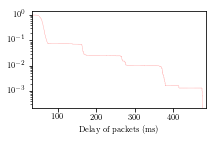

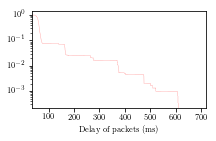

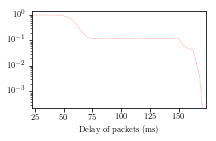

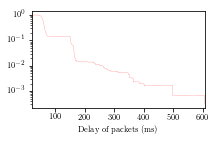

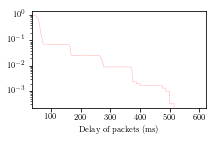

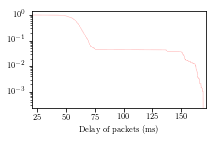

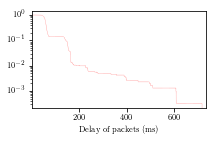

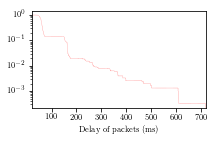

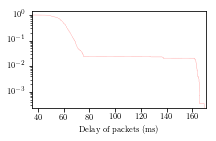

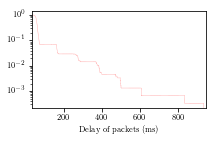

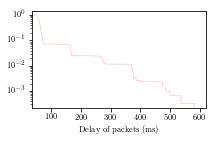

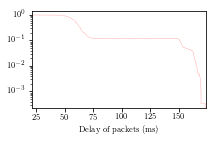

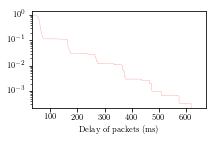

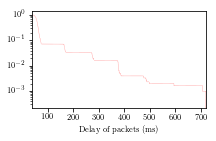

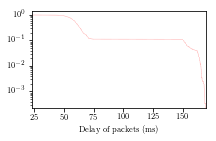

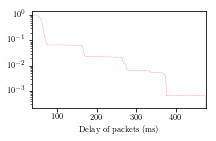

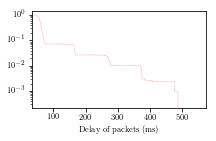

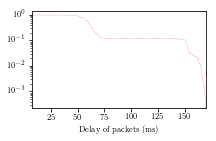

In [199]:
#CCDFs
# one-way delay (stream layer)
for f in glob.iglob('./crosstraffic_mqs-6/*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfstream['length']
    print(f)
    
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    sortedOneWayDelay = dfstream['onewaydelay'].sort_values()
    print(sortedOneWayDelay.size)
    
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfstream.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)
            
    print('Outdated:', outdated.size, 'min:', outdated.min(), 'mean:', outdated.mean(), 
            'median:', outdated.median(), 'max:', outdated.max(), ' (all delays in ms)')
    print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
            'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)\n')
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedOneWayDelay))
    cdf = pd.Series(cum_dist, index=sortedOneWayDelay)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Delay of packets (ms)')
    fig.set_yscale('log')
    plt.tight_layout()
    plt.savefig(f+"ccdf_one-way-delay_stream.pdf")

./ge\20191206-1404-ge-loss2--non-ephemeral\
Hole sizes (ms): occurrences= 0 min= nan mean= nan median= nan max= nan
Hole sizes (msgs): occurrences= 0 min= nan mean= nan median= nan max= nan 

./ge\20191206-1414-ge-loss2--light-ephemeral\
Hole sizes (ms): occurrences= 1 min= 200.092 mean= 200.09 median= 200.09 max= 200.092
Hole sizes (msgs): occurrences= 1 min= 2 mean= 2.0 median= 2.0 max= 2 

./ge\20191206-1425-ge-loss2--full-ephemeral\
Hole sizes (ms): occurrences= 1 min= 200.195 mean= 200.2 median= 200.2 max= 200.195
Hole sizes (msgs): occurrences= 1 min= 2 mean= 2.0 median= 2.0 max= 2 

./ge\20191206-1435-ge-loss4--non-ephemeral\
Hole sizes (ms): occurrences= 18 min= 205.158 mean= 1092.22 median= 898.1 max= 3449.14
Hole sizes (msgs): occurrences= 18 min= 2 mean= 10.72 median= 9.0 max= 34 

./ge\20191206-1445-ge-loss4--light-ephemeral\
Hole sizes (ms): occurrences= 15 min= 200.005 mean= 613.98 median= 600.11 max= 1299.911
Hole sizes (msgs): occurrences= 15 min= 2 mean= 6.13 median= 6

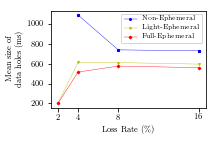

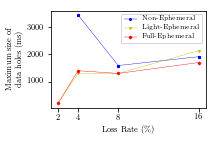

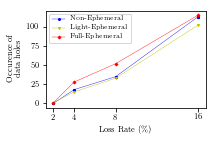

In [185]:
# HOLES: APP LEVEL
# msgs consecutively lost (holes)
experiments = []
                        #/random/ or /ge/
for f in glob.iglob('./ge/*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfstream['length']
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    
    holes = []
    h=1;
    case=''
    for i, seconds in enumerate(dfapp.seconds_offset):
        if (i+1 < dfapp.seconds_offset.size): #out of bounds check
            t1 = seconds;
            t2 = dfapp.seconds_offset[i+1]
            n1 = dfapp.msg_number[i]
            n2 = dfapp.msg_number[i+1]
            if(t2 - t1 > 0.2): # hole detected by offset (but maybe msg before was also outdated!)
                
                if(dfapp.onewaydelay[i] < 100): # was msg[i] already outdated?
                    # msg[i] not outdated
                    
                    if(dfapp.onewaydelay[i+1] > 100): #is msg[i+1] actually the end of the hole?
                        k=2 #look forward until next "msg-in-time" was found
                        while (dfapp.index[i+k] != None and dfapp.onewaydelay[i+k] > 100):
                            k+=1
                        if(dfapp.index[i+k]) != None:
                            n2 = dfapp.msg_number[i+k]
                            t2 = dfapp.seconds_offset[i+k]
                            case = 'i to i+k'
                    else:
                        case = 'i to i+1'
                        
                else:
                    # msg[i] is outdated
                    
                    j=1 # look back until last "msg-in-time" was found
                    while (dfapp.onewaydelay[i-j] > 100):
                        j+=1
                    n1 = dfapp.msg_number[i-j] #update real beginning of hole
                    t1 = dfapp.seconds_offset[i-j]
                    
                    if(dfapp.onewaydelay[i+1] > 100): #is it actually the end of the hole?
                        k=2 #look forward until next "msg-in-time" was found
                        while (dfapp.index[i+k] != None and dfapp.onewaydelay[i+k] > 100):
                            k+=1
                        if(dfapp.index[i+k]) != None:
                            n2 = dfapp.msg_number[i+k]
                            t2 = dfapp.seconds_offset[i+k]
                            case = 'i-j to i+k'
                        else:
                            print('OUT OF BOUNDS')
                    else: # it is already the end
                        case = 'i-j to i+1'
                        
                holes.append([n1, n2, n2-n1, (t2-t1) * 1000, case]) # msg 1, msg 2, msg difference, time difference
                #print(h, case, [n1, n2, n2-n1, str(round((t2-t1) * 1000, 2))])
                #h+=1
    
    holeTimes = pd.Series(i[3] for i in holes)
    holeMsgs = pd.Series(i[2] for i in holes)
    
    print('Hole sizes (ms): occurrences=', holeTimes.size, 'min=', holeTimes.min(), 'mean=', round(holeTimes.mean(), 2), 'median=', round(holeTimes.median(), 2), 
          'max=', holeTimes.max())
    print('Hole sizes (msgs): occurrences=', holeMsgs.size, 'min=', holeMsgs.min(), 'mean=', round(holeMsgs.mean(), 2), 'median=', round(holeMsgs.median(), 2), 
          'max=', holeMsgs.max(), '\n')
    
   
    #set parameters and check if occurences = 0 -> mean, median, max also 0 then
    
    experimentName=f[f.find('2019'):]
    #print(experimentName)
    experiments.append([experimentName, holeTimes.size, round(holeTimes.mean(), 2), round(holeTimes.median(), 2), holeTimes.max()])
    #experiments.append([experimentName, holeTimes.mean()])

# build dataframes from values computed above
#pprint(experiments)

dfNE = pd.DataFrame()
dfNE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments if ('non-ephemeral' in i[0]))
dfNE['occurrences'] = pd.Series(i[1] for i in experiments if ('non-ephemeral' in i[0]))
dfNE['mean'] = pd.Series(i[2] for i in experiments if ('non-ephemeral' in i[0]))
dfNE['median'] = pd.Series(i[3] for i in experiments if ('non-ephemeral' in i[0]))
dfNE['max'] = pd.Series(i[4] for i in experiments if ('non-ephemeral' in i[0]))

dfLE = pd.DataFrame()
dfLE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments if ('light-ephemeral' in i[0]))
dfLE['occurrences'] = pd.Series(i[1] for i in experiments if ('light-ephemeral' in i[0]))
dfLE['mean'] = pd.Series(i[2] for i in experiments if ('light-ephemeral' in i[0]))
dfLE['median'] = pd.Series(i[3] for i in experiments if ('light-ephemeral' in i[0]))
dfLE['max'] = pd.Series(i[4] for i in experiments if ('light-ephemeral' in i[0]))

dfFE = pd.DataFrame()
dfFE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments if ('full-ephemeral' in i[0]))
dfFE['occurrences'] = pd.Series(i[1] for i in experiments if ('full-ephemeral' in i[0]))
dfFE['mean'] = pd.Series(i[2] for i in experiments if ('full-ephemeral' in i[0]))
dfFE['median'] = pd.Series(i[3] for i in experiments if ('full-ephemeral' in i[0]))
dfFE['max'] = pd.Series(i[4] for i in experiments if ('full-ephemeral' in i[0]))


print(dfNE, '\n', dfLE, '\n', dfFE) 


# MEAN (in ms)
fig = dfNE.plot(x="lossrate", y="mean", kind='scatter', color="DarkBlue", s=5)
x = dfNE.lossrate
y = dfNE['mean']
fig.plot(x, y, 'b', marker="o", ms=2)
x = dfLE.lossrate
y1 = dfLE['mean']
fig.plot(x, y1, 'y', marker="v", ms=2)
x = dfFE.lossrate
y2 = dfFE['mean']
fig.plot(x, y2, 'r', marker="D", ms=2)

fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

plt.xticks(dfNE.lossrate.tolist())
fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Mean size of\ndata holes (ms)')
plt.tight_layout()
plt.savefig(f+"dataholes_mean.pdf")

# MAX (in ms)
fig = dfNE.plot(x="lossrate", y="max", kind='scatter', color="DarkBlue", s=5)
x = dfNE.lossrate
y = dfNE['max']
fig.plot(x, y, 'b', marker="o", ms=2)
x = dfLE.lossrate
y1 = dfLE['max']
fig.plot(x, y1, 'y', marker="v", ms=2)
x = dfFE.lossrate
y2 = dfFE['max']
fig.plot(x, y2, 'r', marker="D", ms=2)

fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

plt.xticks(dfNE.lossrate.tolist())
fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Maximum size of\ndata holes (ms)')
plt.tight_layout()
plt.savefig(f+"dataholes_max.pdf")


# OCCURRENCES (in number of holes)
fig = dfNE.plot(x="lossrate", y="occurrences", kind='scatter', color="DarkBlue", s=5)
x = dfNE.lossrate
y = dfNE['occurrences']
fig.plot(x, y, 'b', marker="o", ms=2)
x = dfLE.lossrate
y1 = dfLE['occurrences']
fig.plot(x, y1, 'y', marker="v", ms=2)
x = dfFE.lossrate
y2 = dfFE['occurrences']
fig.plot(x, y2, 'r', marker="D", ms=2)

fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best") #bbox_to_anchor=(1,1)

plt.xticks(dfNE.lossrate.tolist())
fig.set_xlabel('Loss Rate (\%)')
fig.set_ylabel('Occurence of\ndata holes')

plt.tight_layout()
plt.savefig(f+"dataholes_occurences.pdf")


./ge\20191206-1404-ge-loss2--non-ephemeral\
./ge\20191206-1414-ge-loss2--light-ephemeral\
./ge\20191206-1425-ge-loss2--full-ephemeral\
./ge\20191206-1435-ge-loss4--non-ephemeral\
./ge\20191206-1445-ge-loss4--light-ephemeral\
./ge\20191206-1455-ge-loss4--full-ephemeral\
./ge\20191206-1506-ge-loss8--non-ephemeral\
./ge\20191206-1516-ge-loss8--light-ephemeral\
./ge\20191206-1526-ge-loss8--full-ephemeral\
./ge\20191206-1537-ge-loss16--non-ephemeral\
./ge\20191206-1547-ge-loss16--light-ephemeral\
./ge\20191206-1557-ge-loss16--full-ephemeral\


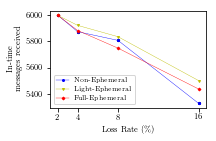

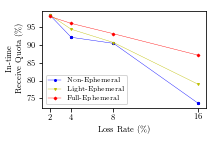

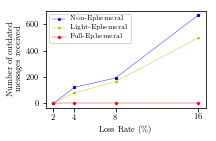

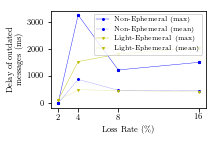

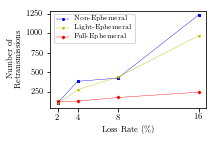

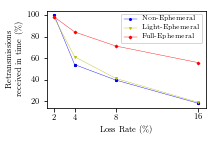

In [187]:
#Client message retries
experiments2 = []
                        #/random/ or /ge/
for f in glob.iglob('./ge/*201912*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msg_number'])
    title=f
    print(f)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfclient['duplicate'] = dfclient.msg_number.duplicated()
    
    retryList = [];
    retryWithoutDuplicates = [];
    for i, value in enumerate(dfclient.duplicate):
        if(value):
            retryList.append(dfclient.msg_number[i])
            if(dfclient.msg_number[i] not in retryWithoutDuplicates):
                retryWithoutDuplicates.append(dfclient.msg_number[i])
    
    retriesPerMsg = [];
    for msgID in retryList:
        if(msgID not in retriesPerMsg):
            retriesPerMsg.append(retryList.count(msgID))
    
    retries = pd.Series(retriesPerMsg)
    
    #look if the retransmit messages have arrived
    arrivedRetransmits = [];

    for msg in retryWithoutDuplicates:
        if dfstream.msg_number[dfstream.msg_number == msg].size > 0:
            arrivedRetransmits.append(msg)
    
    #look if the arrived retransmits have arrived in time
    retransInTime = [];
    for msgnumber in arrivedRetransmits:
        if dfstream.msg_number[dfstream.msg_number == msgnumber].size > 0:
            index = dfstream.msg_number[dfstream.msg_number == msgnumber].index[0]
            if dfstream.onewaydelay[index] < 100: #maybe with app value?
                retransInTime.append([dfstream.msg_number[index], dfstream.onewaydelay[index]])
                
                
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfapp.onewaydelay):
        if(value>100):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)

            
    received = dfapp.onewaydelay.size
    
            
    if(outdated.size==0): 
        outdatedsize=0;
        outdatedmean=0;
        outdatedmax=0;
    else:
        outdatedsize=outdated.size;
        outdatedmean=outdated.mean();
        outdatedmax=outdated.max();
        
    #print('Messages received:', dfapp.onewaydelay.size)
    #print('Outdated:', outdated.size, 'min:', outdated.min(), 'mean:', outdated.mean(), 
    #        'median:', outdated.median(), 'max:', outdated.max(), ' (all delays in ms)')
    #print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
    #        'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)')
 
    #print('Retransmissions by client:', len(retryList), 'for', len(retryWithoutDuplicates), 'different messages with', len(arrivedRetransmits),'(', round(len(arrivedRetransmits)/len(retryWithoutDuplicates)*100,2) , '%) of them arrived')
    #print('retries in time:', len(retransInTime), '(', round(len(retransInTime)/len(retryWithoutDuplicates) * 100, 2) ,'%)', 'not in time', len(arrivedRetransmits)-len(retransInTime))
    #print('mean tries per msg:', round(retries.mean(), 2), 'max tries per msg:', retries.max())
    
    experimentName=f[16:]
    experiments2.append([experimentName, dfapp.onewaydelay.size, inTime.size, outdatedsize, outdatedmean, outdatedmax, len(retryList), len(retryWithoutDuplicates), len(arrivedRetransmits), len(retransInTime), round(len(retransInTime)/len(retryWithoutDuplicates) * 100, 2), len(arrivedRetransmits)-len(retransInTime), dfclient.seconds_offset.size, dfstream.seconds_offset.size, round(inTime.size/dfclient.seconds_offset.size *100, 2)])

# build dataframes from values computed above
#pprint(experiments2)

dfNE = pd.DataFrame()
dfNE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['received'] = pd.Series(i[1] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['inTime'] = pd.Series(i[2] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['outdated'] = pd.Series(i[3] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['outdated_mean'] = pd.Series(i[4] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['outdated_max'] = pd.Series(i[5] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retransmissions'] = pd.Series(i[6] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_wo_dup'] = pd.Series(i[7] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_arrived'] = pd.Series(i[8] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_inTime'] = pd.Series(i[9] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_inTime_percent'] = pd.Series(i[10] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['retrans_not_inTime'] = pd.Series(i[11] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['sentByClient'] = pd.Series(i[12] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['receivedOnStreamByServer'] = pd.Series(i[13] for i in experiments2 if ('non-ephemeral' in i[0]))
dfNE['good_receive_rate'] = pd.Series(i[14] for i in experiments2 if ('non-ephemeral' in i[0]))

dfLE = pd.DataFrame()
dfLE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['received'] = pd.Series(i[1] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['inTime'] = pd.Series(i[2] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['outdated'] = pd.Series(i[3] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['outdated_mean'] = pd.Series(i[4] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['outdated_max'] = pd.Series(i[5] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retransmissions'] = pd.Series(i[6] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_wo_dup'] = pd.Series(i[7] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_arrived'] = pd.Series(i[8] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_inTime'] = pd.Series(i[9] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_inTime_percent'] = pd.Series(i[10] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['retrans_not_inTime'] = pd.Series(i[11] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['sentByClient'] = pd.Series(i[12] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['receivedOnStreamByServer'] = pd.Series(i[13] for i in experiments2 if ('light-ephemeral' in i[0]))
dfLE['good_receive_rate'] = pd.Series(i[14] for i in experiments2 if ('light-ephemeral' in i[0]))

dfFE = pd.DataFrame()
dfFE['lossrate'] = pd.Series(int(i[0][i[0].rfind('ss')+2:i[0].find('--')]) for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['received'] = pd.Series(i[1] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['inTime'] = pd.Series(i[2] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['outdated'] = pd.Series(i[3] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['outdated_mean'] = pd.Series(i[4] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['outdated_max'] = pd.Series(i[5] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retransmissions'] = pd.Series(i[6] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_wo_dup'] = pd.Series(i[7] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_arrived'] = pd.Series(i[8] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_inTime'] = pd.Series(i[9] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_inTime_percent'] = pd.Series(i[10] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['retrans_not_inTime'] = pd.Series(i[11] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['sentByClient'] = pd.Series(i[12] for i in experiments2 if ('full-ephemeral' in i[0]))
dfNE['receivedOnStreamByServer'] = pd.Series(i[13] for i in experiments2 if ('full-ephemeral' in i[0]))
dfFE['good_receive_rate'] = pd.Series(i[14] for i in experiments2 if ('full-ephemeral' in i[0]))


if(dfNE.size != 0):
    
# messages in time
    fig = dfNE.plot(x="lossrate", y="inTime", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['inTime']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['inTime']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['inTime']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('In-time\nmessages received')
    plt.tight_layout()
    plt.savefig(f+"msgs_intime.pdf")

# messages in time
    fig = dfNE.plot(x="lossrate", y="good_receive_rate", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['good_receive_rate']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['good_receive_rate']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['good_receive_rate']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('In-time\nReceive Quota (\%)')
    plt.tight_layout()
    plt.savefig(f+"msgs_receiveRate.pdf")


# outdated messages
    fig = dfNE.plot(x="lossrate", y="outdated", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['outdated']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['outdated']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['outdated']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Number of outdated\nmessages received')
    plt.tight_layout()
    plt.savefig(f+"msgs_outdated.pdf")

# outdated messages (mean and max in ms)
    fig = dfNE.plot(x="lossrate", y="outdated_max", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['outdated_max']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfNE.lossrate
    y2 = dfNE['outdated_mean']
    fig.plot(x, y2, 'b:', marker="o", ms=2)

    x = dfLE.lossrate
    y1 = dfLE['outdated_max']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfLE.lossrate
    y3 = dfLE['outdated_mean']
    fig.plot(x, y3, 'y:', marker="v", ms=2)

    fig.legend(['Non-Ephemeral (max)', 'Non-Ephemeral (mean)', 'Light-Ephemeral (max)', 'Light-Ephemeral (mean)'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Delay of outdated\nmessages (ms)')
    plt.tight_layout()
    plt.savefig(f+"msgs_outdated_mean-max.pdf")



# retransmissions
    fig = dfNE.plot(x="lossrate", y="retransmissions", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['retransmissions']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['retransmissions']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['retransmissions']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Number of\nRetransmissions')
    plt.tight_layout()
    plt.savefig(f+"msgs_retransmissions.pdf")


# retransmissions received in time (%)
    fig = dfNE.plot(x="lossrate", y="retrans_inTime_percent", kind='scatter', color="DarkBlue", s=5)
    x = dfNE.lossrate
    y = dfNE['retrans_inTime_percent']
    fig.plot(x, y, 'b', marker="o", ms=2)
    x = dfLE.lossrate
    y1 = dfLE['retrans_inTime_percent']
    fig.plot(x, y1, 'y', marker="v", ms=2)
    x = dfFE.lossrate
    y2 = dfFE['retrans_inTime_percent']
    fig.plot(x, y2, 'r', marker="D", ms=2)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")

    plt.xticks(dfNE.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('Retransmissions\nreceived in time (\%)')
    plt.tight_layout()
    plt.savefig(f+"msgs_retrans_inTime.pdf")


Non-Ephemeral
    lossrate  received  inTime  outdated  outdated_mean  outdated_max  \
0         2      6000    6000         0       0.000000         0.000   
1         4      5994    5873       121     880.010909      3251.740   
2         8      6000    5807       193     480.754534      1228.484   
3        16      6000    5328       672     470.696564      1508.224   

   retransmissions  retrans_wo_dup  retrans_arrived  retrans_inTime  \
0              104             104              104             104   
1              382             241              241             130   
2              423             311              311             123   
3             1233             790              790             142   

   retrans_inTime_percent  retrans_not_inTime  sentByClient  \
0                  100.00                   0          6104   
1                   53.94                 111          6376   
2                   39.55                 188          6423   
3               

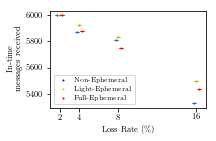

In [188]:
print('Non-Ephemeral\n', dfNE, '\nLight-Ephemeral\n', dfLE, '\nFull-Ephemeral\n', dfFE)

# for every version: 
# compute mean, and get min and max for every lossrate over all runs
# plot the mean, with errorbar yerr=max-min

dfAll = pd.DataFrame()
dfAll['NE-inTime-mean'] = dfNE.groupby('lossrate')['inTime'].mean()
dfAll['NE-inTime-max'] = dfNE.groupby('lossrate')['inTime'].max()
dfAll['NE-inTime-min'] = dfNE.groupby('lossrate')['inTime'].min()
dfAll['NE-inTime-var'] = dfAll['NE-inTime-max']-dfAll['NE-inTime-min']

dfAll['LE-inTime-mean'] = dfLE.groupby('lossrate')['inTime'].mean()
dfAll['LE-inTime-max'] = dfLE.groupby('lossrate')['inTime'].max()
dfAll['LE-inTime-min'] = dfLE.groupby('lossrate')['inTime'].min()
dfAll['LE-inTime-var'] = dfAll['LE-inTime-max']-dfAll['LE-inTime-min']

dfAll['FE-inTime-mean'] = dfFE.groupby('lossrate')['inTime'].mean()
dfAll['FE-inTime-max'] = dfFE.groupby('lossrate')['inTime'].max()
dfAll['FE-inTime-min'] = dfFE.groupby('lossrate')['inTime'].min()
dfAll['FE-inTime-var'] = dfAll['FE-inTime-max']-dfAll['FE-inTime-min']

dfAll.reset_index(inplace=True)
print(dfAll)

cap=2; #capsize for errorbars
mark=1; #markersize for plots
lin='None';
shift=0.25

if(dfAll.size != 0):
    # messages received in time with variance
    fig = dfAll.plot(x="lossrate", y="LE-inTime-mean", kind='scatter', color="y", s=1)
    
    x = dfAll.lossrate.apply(lambda x: x-shift)
    y = dfAll['NE-inTime-mean']
    yerr = dfAll['NE-inTime-var']
    fig.plot(x, y, 'b', marker="o", ms=mark, color='b', ls=lin)
    fig.errorbar(x, y, yerr, capsize=cap, ls=lin)
    
    x1 = dfAll.lossrate
    y1 = dfAll['LE-inTime-mean']
    yerr1 = dfAll['LE-inTime-var']
    fig.plot(x1, y1, 'y', marker="v", ms=mark, ls=lin)
    fig.errorbar(x1, y1, yerr1, capsize=cap, color='y', ls=lin)
    
    x2 = dfAll.lossrate.apply(lambda x: x+shift)
    y2 = dfAll['FE-inTime-mean']
    yerr2 = dfAll['FE-inTime-var']
    fig.plot(x2, y2, 'r', marker="D", ms=mark, ls=lin)
    fig.errorbar(x2, y2, yerr2, capsize=cap, color='r', ls=lin)

    fig.legend(['Non-Ephemeral', 'Light-Ephemeral', 'Full-Ephemeral'], loc="best")
    
    #fig.set_xscale('log')
    plt.xticks(dfAll.lossrate.tolist())
    fig.set_xlabel('Loss Rate (\%)')
    fig.set_ylabel('In-time\nmessages received')
    plt.tight_layout()
    plt.savefig(f+"msgs_intime+variance.pdf")

In [ ]:
# outdated holes
# 1. STREAM LEVEL 
# 2. APP LEVEL
# msgs consecutively lost (holes)
for f in glob.iglob('./*20191204*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfstream['length']
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    diffList = []; # [difference, n1, n2] -> when negative, outdated data. When positive, hole
                # !! when APP not STREAM used, than non-ephemeral has no holes since it reorders on app-level
   
    outdatedList = []; # how many outdated messages were processed
    
    holeList = []; # how big are the data holes
    holeTimeList = []; # what are sizes of the holes in time
    
    for i, number in enumerate(dfstream['msg_number']):
        if i+1 < dfstream.msg_number.size:
            n1 = dfstream.msg_number[i]
            n2 = dfstream.msg_number[i+1]
            if n2 != n1+1:
                timedDiff=0
                if(n2 > n1):
                    timedDiff = dfapp.seconds_offset[i+1]*1000 - dfapp.seconds_offset[i]*1000
                    holeTimeList.append(timedDiff)
                diffList.append([n2-n1, n1, n2])
                #print(n2-n1, n1, n2, str(timedDiff))
    
    for j in diffList:
        if j[0] < 0:
            outdatedList.append(j)
        else:
            holeList.append(j)
            
    outdated = pd.Series(i[0] for i in outdatedList)
    holes = pd.Series(i[0] for i in holeList)
    holeTimes = pd.Series(holeTimeList)
    print('# STREAM LEVEL')
    print('Outdated by: min=', outdated.min(), 'mean=', outdated.mean(), 'median=', outdated.median(), 'max=', outdated.max(), 'occurences=', outdated.size)
    print('Hole times: min=', holeTimes.min(), 'mean=', holeTimes.mean(), 'median=', holeTimes.median(), 'max=', holeTimes.max(), 'occurences=', holeTimes.size)
    print('Hole sizes: min=', holes.min(), 'mean=', holes.mean(), 'median=', holes.median(), 'max=', holes.max(), 'occurences=', holes.size, '\n')
    
    
    #APP LEVEL
    print('# APP LEVEL')

    #delete every outdated packet at first?
    filtered = [];
    for sec in dfapp[dfapp['onewaydelay'] < 100].seconds_offset:
        filtered.append(sec);
    
    holeDetect = [];
    for i, seconds in enumerate(filtered):
        if i+1 < len(filtered):
            t1 = filtered[i]
            t2 = filtered[i+1]
            if t2-t1 > 0.2:
                holeDetect.append([filtered[i], filtered[i+1], (t2-t1)*1000])
                #print((t2-t1)*1000)
    
    holeTimesApp = pd.Series(i[2] for i in holeDetect)
    print('Hole sizes (ms) [filtered]: min=', holeTimesApp.min(), 'mean=', holeTimesApp.mean(), 'median=', holeTimesApp.median(), 
          'max=', holeTimesApp.max(), 'occurences=', holeTimesApp.size)
    
    holeDetect = [];
    for i, seconds in enumerate(dfapp.seconds_offset):
        if i+1 < len(dfapp.seconds_offset):
            t1 = dfapp.seconds_offset[i]
            t2 = dfapp.seconds_offset[i+1]
            if t2-t1 > 0.2:
                holeDetect.append([dfapp.seconds_offset[i], dfapp.seconds_offset[i+1], (t2-t1)*1000])
                #print((t2-t1)*1000)
    
    holeTimesApp = pd.Series(i[2] for i in holeDetect)
    print('Hole sizes (ms) [unfiltered]: min=', holeTimesApp.min(), 'mean=', holeTimesApp.mean(), 'median=', holeTimesApp.median(), 
          'max=', holeTimesApp.max(), 'occurences=', holeTimesApp.size, '\n')

In [ ]:
#CCDFs
# time between consecutive msgs (should be under the deadline)
for f in glob.iglob('./*20191203*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfapp['length']
    print(f)
    
    #compute the time between two consecutive packets
    dfapp.sort_values(by='msg_number')
    dfapp['ms_offset'] = dfapp.seconds_offset.apply(lambda x: x * 1000) # from s to ms
    #print(dfapp)
    
    i = dfapp.ms_offset[0];
    timeBetween = [];
    for j in dfapp['ms_offset']:
        timeBetween.append(j-i)
        i = j
        
    dfapp['timeBetweenMsgs'] = timeBetween
    sortedTimesBetweenMsgs = dfapp['timeBetweenMsgs'].sort_values()
    #print(sortedTimesBetweenMsgs)
    #print(dfapp.sort_values(by='timeBetweenMsgs'))
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedTimesBetweenMsgs))
    cdf = pd.Series(cum_dist, index=sortedTimesBetweenMsgs)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between packets (ms)')
    #fig.set_yscale('log')
    plt.tight_layout()
    plt.savefig(f+"ccdf_timeBetweenMsgs.pdf")

In [ ]:
#CCDFs
# time between actual msgs arrival and perfect arrical time
for f in glob.iglob('./*20191203*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfapp['length']
    
    #compute the time between actual arrival time and perfect arrival time
    dfapp.sort_values(by='msg_number')
    
    #starttime = dfapp.seconds_offset[0] - 0.1
    #print(starttime)
    
    dfapp['ms_offset'] = dfapp.seconds_offset.apply(lambda x: x * 1000) # from s to ms
    dfapp['perfectTimeDeviation'] = dfapp.ms_offset - dfapp.msg_number * 100
    #print(dfapp)

    sortedTimeDeviation = dfapp['perfectTimeDeviation'].sort_values()
    #print(sortedTimeDeviation)
    #print(dfapp)
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedTimeDeviation))
    cdf = pd.Series(cum_dist, index=sortedTimeDeviation)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between actual arrival \n and perfect arrival time (ms)')
    plt.tight_layout()
    
    #plt.savefig(f+"ccdf_perfectTimeDeviation.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"all_ccdf_perfectTimeDeviation_ylog.pdf")

In [ ]:
#PING: single experiment
#SCATTERPLOT - PING + rtt values over time
'''
for f in glob.iglob('./*1016-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'ack_delay', 'srtt', 'rtt_var', 'state'])
                                                        # KPIs FROM BEFORE 18.10.2019!
                                                        
    #dping = pd.read_csv('./20191015-1314_1hr_ping/20191015-1314_client_ping_grep', delim_whitespace=True, 
                        names = ['seconds_offset', 'ping_number', 'ping_rtt'])
    
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    print(df.current_rtt.mean(),
          df.srtt.mean(),
          dping.ping_rtt.mean())
    
    
    fig = dping.plot(x="ping_number", y="ping_rtt", kind='scatter', color="DarkBlue", s=0.01)
    x = df.seconds_offset
    y1 = df.current_rtt
    fig.plot(x,y1,'r:') # more examples = 'b:' 'k:' 'r--'
    y2 = df.srtt
    fig.plot(x,y2, 'y:')

    axes = plt.gca()
    fig.legend(['Current RTT', 'Smoothed RTT', 'Ping RTT'])
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing+ping.pdf")
    
    axes.set_ylim([0,250])
    #axes.set_xlim([-5,605])
    plt.savefig(f+"_timing+ping_limit.pdf")
'''

In [ ]:
#WiFi vs ETH
#BOXPLOT - application RTT (current rtt)
dfe100 = pd.read_csv('./analysis_wifi-vs-eth/eth_100ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
dfe200 = pd.read_csv('./analysis_wifi-vs-eth/eth_200ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfe500 = pd.read_csv('./analysis_wifi-vs-eth/eth_500ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw100 = pd.read_csv('./analysis_wifi-vs-eth/wifi_100ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw200 = pd.read_csv('./analysis_wifi-vs-eth/wifi_200ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw500 = pd.read_csv('./analysis_wifi-vs-eth/wifi_500ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])

dfe100 = dfe100[dfe100.index % 2 != 0]
dfe100 = dfe100[dfe100.state == 15]
dfe200 = dfe200[dfe200.index % 2 != 0]
dfe200 = dfe200[dfe200.state == 15]
dfe500 = dfe500[dfe500.index % 2 != 0]
dfe500 = dfe500[dfe500.state == 15]

dfw100 = dfw100[dfw100.index % 2 != 0]
dfw100 = dfw100[dfw100.state == 15]
dfw200 = dfw200[dfw200.index % 2 != 0]
dfw200 = dfw200[dfw200.state == 15]
dfw500 = dfw500[dfw500.index % 2 != 0]
dfw500 = dfw500[dfw500.state == 15]

df = pd.DataFrame()
df['dfe100'] = dfe100.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe200'] = dfe200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe500'] = dfe500.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw100'] = dfw100.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw200'] = dfw200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw500'] = dfw500.current_rtt.apply(lambda x: x / 1000) #from us to ms

print('Ethernet 100ms: ', df.dfe100.min(), '(min) ', df.dfe100.max(), '(max) ', df.dfe100.median(), '(median) ', '\n',
      'Ethernet 200ms: ', df.dfe100.min(), '(min) ', df.dfe200.max(), '(max) ', df.dfe200.median(), '(median) ', '\n',
      'Ethernet 500ms: ', df.dfe100.min(), '(min) ', df.dfe500.max(), '(max) ', df.dfe500.median(), '(median) ', '\n',
      'WiFi 100ms: ', df.dfw100.min(), '(min) ', df.dfw100.max(), '(max) ', df.dfw100.median(), '(median) ', '\n',
      'WiFi 200ms: ', df.dfw200.min(), '(min) ', df.dfw200.max(), '(max) ', df.dfw200.median(), '(median) ', '\n',
      'WiFi 500ms: ', df.dfw500.min(), '(min) ', df.dfw500.max(), '(max) ', df.dfw500.median(), '(median) ', '\n')


#print(df.to_string())

fig = df.boxplot(showfliers=True, flierprops={'markersize': 1, 'marker': 'x',
                                              'markerfacecolor': 'none', 'markeredgecolor': 'black'}) 
                #showfliers=False -> circles outside of the boxplot
    
fig.set_yscale('log')

plt.xticks([1, 2, 3, 4, 5, 6], ['100', '200\nEthernet\n(interval in ms)', '500', '100', '200\nWiFi\n(interval in ms)', '500'])
fig.set_ylabel('RTT (ms)')
plt.tight_layout()
plt.savefig("./analysis_wifi-vs-eth/rtt_boxplots_wifi-vs-eth_100-200-500ms_ylog_fliers.pdf")


In [ ]:
#WiFi vs ETH
#BOXPLOT - application RTT (current rtt)

dfw200 = pd.read_csv('./eth-vs-wifi/20191025-1451_200ms-5min_wifi_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw200_long = pd.read_csv('./eth-vs-wifi/20191023-1635_200ms-2hr_wifi_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfe200 = pd.read_csv('./eth-vs-wifi/20191029-1406_200ms-5min_eth_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 

df = pd.DataFrame()
df['dfw200_long'] = dfw200_long.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw200'] = dfw200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe200'] = dfe200.current_rtt.apply(lambda x: x / 1000) #from us to ms

print(df.to_string())

fig = df.boxplot()

plt.xticks([1, 2, 3], ['WiFi 200ms', 'WiFi 200ms', 'Eth 200ms'])
fig.set_ylabel('Time (ms)')
plt.tight_layout()
plt.savefig("./eth-vs-wifi/rtt_boxplots_200ms.pdf")


In [ ]:
#SCATTERPLOT - rtt values over time
for f in glob.iglob('./*1023-*200ms*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
        
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    df.rtt_min = df.rtt_min.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    print(df.current_rtt.mean(),
          df.srtt.mean())
    
    fig = df.plot(x="seconds_offset", y="rtt_min", kind='scatter', color="DarkBlue", s=0.01)
    x = df.seconds_offset
    y2 = df.srtt
    fig.plot(x,y2, 'y.')
    y1 = df.current_rtt
    fig.plot(x,y1, 'r.') # more examples = 'b:' 'k:' 'r--'

    axes = plt.gca()
    fig.legend(['Current RTT', 'Smoothed RTT', 'min RTT'])
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing.pdf")
    
    axes.set_ylim([0,25])
    #axes.set_xlim([-5,1000])
    plt.savefig(f+"_timing_limit.pdf")

In [ ]:
#BOXPLOTS - rtt values (Current RTT + Smoothed RTT)
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    #delete unnecessary data
    df.drop(['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 'rtt_min', 
             'send_time', 'reception_time', 'current_ackdelay', 'rtt_var','max_ackdelay', 'state'], axis=1, inplace=True)
    
    #delete initial values
    df.drop(df.index[0], inplace=True)
    
    fig = plt.figure() #this line makes a plot for every file
    fig = df.boxplot()
    plt.xticks([1, 2], ['Current RTT', 'Smoothed RTT'])
    fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing_boxplots.pdf")

In [ ]:
#SCATTERPLOT - congestion window
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    fig = df.plot(x="seconds_offset", y="cwin", marker=",", markersize="0.01", color="DarkBlue", linestyle="None")

    axes = plt.gca()
    #axes.set_ylim([0,20])
    #axes.set_xlim([-5,605])
    axes.get_legend().remove()
    
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Congestion Window')
    plt.tight_layout()
    plt.savefig(f+"_cwin.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"_cwin_ylog.pdf")

In [ ]:
#SCATTERPLOT retransmissions over time
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.state.count())
    print(num_retrans, "\n")
    
    fig = df.plot(x="seconds_offset", y="state", marker="x", markersize="0.1", color="DarkBlue", linestyle="None")
    
    fig.text(df['seconds_offset'].max()*0.75, 0.95, num_retrans, horizontalalignment='center', verticalalignment='center')
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Retransmission=1')
    plt.tight_layout()
    plt.savefig(f+"_retransOverTime.pdf")


In [ ]:
# CUMULATIVE DISTRIBUTION FUNCTION - time between retransmissions
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    
    #delete the normal (no-retransmission) packets
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.seconds_offset.count())
    print(num_retrans, "\n")
    
    #compute the time between retransmissions
    i = 0;
    timeBetween = [];
    for j in df['seconds_offset']:
        timeBetween.append(j-i)
        i = j
        
    df['timeBetween'] = timeBetween
    sortedRetrans = df['timeBetween'].sort_values()
    #print(sortedRetrans)
    #print(df.seconds_offset)
    
    #build the CDF
    cum_dist = np.linspace(0.,1.,len(sortedRetrans))
    cdf = pd.Series(cum_dist, index=sortedRetrans)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    fig.text(sortedRetrans.max()*0.75, 0, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between retransmissions (s)')
    plt.tight_layout()
    plt.savefig(f+"_cdf_retransTimeBetween.pdf")


In [ ]:
# COMPLEMENTARY CUMULATIVE DISTRIBUTION FUNCTION - time between retransmissions
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    
    #delete the normal (no-retransmission) packets
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.seconds_offset.count())
    print(num_retrans, "\n")
    
    #compute the time between retransmissions
    i = 0;
    timeBetween = [];
    for j in df['seconds_offset']:
        timeBetween.append(j-i)
        i = j
        
    df['timeBetween'] = timeBetween
    sortedRetrans = df['timeBetween'].sort_values()
    #print(sortedRetrans)
    #print(df.seconds_offset)
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedRetrans))
    cdf = pd.Series(cum_dist, index=sortedRetrans)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between retransmissions (s)')
    plt.tight_layout()
    plt.savefig(f+"_ccdf_retransTimeBetween.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"_ccdf_retransTimeBetween_ylog.pdf")
    
    axes = plt.gca() 
    axes.set_xlim([0,100])
    fig.text(60, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')
    plt.savefig(f+"_ccdf_retransTimeBetween_yloglim.pdf")

In [ ]:
#SCATTERPLOT - rtt values over time
#COMPARISON to TIMING VALUES
for f in glob.iglob('./*1023-*200*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    #calculate the comparison value
    df['recept_send'] = df.reception_time - df.send_time
    df['deviation'] = df.recept_send - df.current_rtt
    df = df[df.state == 15] #only values after successful start are comparable (earlier, there is no send or reception time set)
    
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    df.rtt_min = df.rtt_min.apply(lambda x: x / 1000)
    df.recept_send = df.recept_send.apply(lambda x: x / 1000)
    df.deviation = df.deviation.apply(lambda x: x / 1000)
    df.current_ackdelay = df.current_ackdelay.apply(lambda x: x / 1000)
    df.max_ackdelay = df.max_ackdelay.apply(lambda x: x / 1000)
    
    title=f
    print(f)
    
    print('Current RTT mean: ' + str(df.current_rtt.mean()) + '\n',
          'SRTT mean: ' + str(df.srtt.mean()) + '\n',
         'Calculated reception-send mean: ' + str(df.recept_send.mean()) + '\n',
         'Deviation mean: ' + str(df.deviation.mean()) + '\n')
    
    standard = 0; #1 = standard plot over time
                  #0 = deviation plotted over time
    
    if(standard):
        fig = df.plot(x="seconds_offset", y="rtt_min", kind='scatter', color="DarkBlue", s=0.01)
        x = df.seconds_offset
        y1 = df.current_rtt
        fig.plot(x,y1,'r:') # more examples = 'b:' 'k:' 'r--'
        y2 = df.recept_send
        fig.plot(x,y2, 'y:')

        axes = plt.gca()
        fig.legend(['Current RTT', 'recept minus send', 'min RTT'])
        fig.set_xlabel('Runtime (seconds)')
        lines = fig.set_ylabel('Time (ms)')
        plt.tight_layout()
        plt.savefig(f+"_timing-comparison.pdf")
    
    #Plotting only deviation values
    else:
        df['deviation'] = df['deviation'].replace(0.0, np.nan) #set all 0.0 to NaN -> not plotted
        df.dropna(inplace=True)
        print(df[['seconds_offset', 'current_rtt', 'recept_send', 
                  'deviation', 'current_ackdelay', 'max_ackdelay']].to_string(index=False))

        fig = df.plot(x="seconds_offset", y="deviation", kind='scatter', color="DarkBlue", s=0.01)
        x = df.seconds_offset
        
        num_deviations = 'Differences = ' + str(df.deviation.count())
        print(num_deviations, "\n")
        #fig.text(df.seconds_offset.max()*0.9, df.deviation.max()*0.9, num_deviations, horizontalalignment='center', verticalalignment='center')

        axes = plt.gca()
        fig.legend(['Deviation'])
        fig.set_xlabel('Runtime (seconds)  [' + num_deviations + ']')
        lines = fig.set_ylabel('Time (ms)')
        plt.tight_layout()
        plt.savefig(f+"_timing-deviation_cleaned.pdf")

In [ ]:
#SINGLE EXPERIMENT
# Compute the time from pcap files
# Comparison with current_rtt from application

for f in glob.iglob('./*1029-08*/*client_filter_pcap', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, float_precision='round_trip', names = ['seconds_offset', 'framenumber', 'datasize']) 
                                                        #extraction of PCAP: update from 28.10.19
    title=f
    print(f)
    
    dfserver = pd.read_csv('./20191029-0810_500ms-5min_pcap2_eth/server_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])
    
    #TODO: Cut firstKPIs short to cover only the same packets as in filtered PCAP
    dfcomp = pd.read_csv('./20191029-0810_500ms-5min_pcap2_eth/firstKPIs', delim_whitespace=True, 
                        names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                 'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                 'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
    
    #set the indices
    i=0
    j=1
    k=2
    
    rtt1 = []
    rtt2 = []
    frameNumber = []
    frameNumber1 = []
    frameNumber2 = []
    dataSize1 = []
    dataSize2 = []
    
    
    client2server = []
    server2client = []
    serverprocessingtime = []
    
    num_packets = df.seconds_offset.count()/3

    #compute the pcap rtt's: first reply - request = rtt1, 
    #                        second reply - request = rtt2,
    #                        server_receive - client_sent
    for x in range(num_packets.astype(int)):
        frameNumber.append(df.at[i, 'framenumber'])
        rtt1.append(df.at[j, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        frameNumber1.append(df.at[j, 'framenumber'])
        dataSize1.append(df.at[j, 'datasize'])
        rtt2.append(df.at[k, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        frameNumber2.append(df.at[k, 'framenumber'])
        dataSize2.append(df.at[k, 'datasize'])
        
        client2server.append(dfserver.at[i, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        serverprocessingtime.append(dfserver.at[j, 'seconds_offset'] - dfserver.at[i, 'seconds_offset'])
        server2client.append(df.at[j, 'seconds_offset'] - dfserver.at[j, 'seconds_offset'])
        
        i=i+3
        j=j+3
        k=k+3
        
    
    df2 = pd.DataFrame()
    df2['frame'] = frameNumber
    df2['app_rtt'] = dfcomp['current_rtt']
    df2['clientrtt1'] = rtt1
    #df2['frame+1'] = frameNumber1
    #df2['size1'] = dataSize1
    #df2['client_rtt2'] = rtt2
    #df2['frame+2'] = frameNumber2
    #df2['size2'] = dataSize2
    
    df2['client2server'] = client2server
    df2['server2client'] = server2client
    df2['serverprocessingtime'] = serverprocessingtime
    
    df2.app_rtt = df2.app_rtt.apply(lambda x: x / 1000) #from us to ms
    df2.clientrtt1 = df2.clientrtt1.apply(lambda x: x * 1000) #from s to ms
    #df2.client_rtt2 = df2.client_rtt2.apply(lambda x: x * 1000)
    df2.client2server = df2.client2server.apply(lambda x: x * 1000)
    df2.server2client = df2.server2client.apply(lambda x: x * 1000)
    df2.serverprocessingtime = df2.serverprocessingtime.apply(lambda x: x * 1000)
    
    print(df2.to_string())
    
    fig = df2.plot(x="frame", y="clientrtt1", kind='line', color="DarkBlue", linestyle=':')
    
    
    fig.set_xlabel('packet number')
    fig.set_ylabel('measured time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_analysis.pdf")

In [ ]:
#iperf UDP

dfserver = pd.read_csv('./iperf_tests/20191028-1019_udp/server_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])
dfclient = pd.read_csv('./iperf_tests/20191028-1019_udp/client_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])

client2server = []
clienttime = []
client_firstoffset = dfclient.at[0, 'seconds_offset']
servertime = []

for x in range(dfclient.seconds_offset.count()):
    client2server.append(dfserver.at[x, 'seconds_offset'] - dfclient.at[x, 'seconds_offset'])
    #clienttime.append(dfclient.at[x, 'seconds_offset'] - client_firstoffset)
    #servertime.append(dfserver.at[x, 'seconds_offset'] - client_firstoffset)
    

df = pd.DataFrame()
#df['client_time'] = clienttime
#df['server_time'] = servertime
df['client2server'] = client2server

df.client2server = df.client2server.apply(lambda x: x * 1000) #from s to ms


print(df.to_string())


#fig = df.plot()

#fig.set_xlabel('index')
#fig.set_ylabel('measured time (ms)')
#plt.tight_layout()
#plt.savefig("./iperf_tests/20191028-1019_udp/client_filter_pcap_analysis.pdf")

In [ ]:
#iperf TCP

dfserver = pd.read_csv('./iperf_tests/20191029-1136_tcp/server_filter_pcap_acks', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'rtt'])
dfclient = pd.read_csv('./iperf_tests/20191029-1136_tcp/client_filter_pcap_acks', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'rtt'])

dfclient = dfclient.apply(lambda x: x * 1000) #from s to ms
dfserver = dfserver.apply(lambda x: x * 1000)


fig = dfclient.plot(y='rtt', use_index=True)
#x = dfserver.index
#y1 = dfserver.rtt
#fig.plot(x,y1,'r:')

fig.set_xlabel('index')
fig.set_ylabel('measured time (ms)')
plt.tight_layout()
plt.savefig("./iperf_tests/20191029-1136_tcp/client_filter_pcap_analysis.pdf")